# First steps with ReservoirPy

In [1]:
CSV_FILE = "../../data/synthetic_bph_1/simulation.csv"
USE_NOISY_DATA = False
USE_MIXED_EFFECT = False

In [2]:
import sys

TOOL_PATH = "../../tools"
sys.path.append(TOOL_PATH)

In [3]:
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from reservoirpy.nodes import Reservoir, Ridge, Input, ScikitLearnNode

from time_series_modules import train_test_split_on_series, TimeSerieShapeChanger

## Data Loading

In [4]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,...,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.578900,2.609469,1.182835,1.163621,0.337061,0.425037,-0.431840,-0.357768,...,-0.232450,0.831012,1.352299,-0.516725,-0.530378,0,-0.377299,-0.446602,-0.377299,-0.485727
1,1,1,-0.722880,0.632410,1.063808,1.213479,0.336570,0.027890,-0.291742,-0.231186,...,-0.046091,1.100089,0.659184,-0.197166,-0.202305,0,-0.351356,-0.336197,-0.351356,-0.215917
2,1,2,-2.024659,-4.894554,0.994182,1.007263,0.335097,0.190370,-0.164976,-0.228072,...,-0.027549,1.406843,1.589057,-0.054419,-0.062498,0,-0.465150,-0.305957,-0.465150,-0.520721
3,1,3,-3.326438,-1.686564,0.944782,1.016037,0.332642,0.353213,-0.050273,-0.054755,...,-0.002254,1.751273,1.588178,-0.013368,-0.002160,0,-0.593820,-0.562556,-0.593820,-0.540925
4,1,4,-4.628218,-5.122320,0.906464,0.815443,0.329205,0.389886,0.053514,0.104324,...,-0.023248,2.133381,2.310414,-0.003183,-0.018556,0,-0.724237,-0.768777,-0.724237,-0.885692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-23.332007,-23.355913,-4.344100,-4.414434,-0.173962,-0.122074,-1.178537,-1.380993,...,-0.005981,13.776952,13.618513,-1.257165,-1.260118,1,-14.103343,-13.962535,26.986214,26.676660
25496,500,47,-23.805504,-25.684027,-4.367756,-4.504144,-0.225636,-0.238187,-1.177882,-1.235860,...,0.009649,14.593799,14.807169,-1.257178,-1.253582,1,-14.908790,-14.811023,28.732735,28.779230
25497,500,48,-24.279001,-24.921407,-4.390925,-4.286035,-0.278421,-0.347200,-1.177290,-1.228622,...,-0.002082,15.434169,15.402741,-1.257188,-1.264389,1,-15.742044,-15.744676,30.539551,30.650900
25498,500,49,-24.752498,-24.910869,-4.413625,-4.399454,-0.332318,-0.325558,-1.176754,-1.040624,...,0.033597,16.298063,16.347750,-1.257196,-1.251337,1,-16.603254,-16.663303,32.406986,32.383627


In [5]:
serie_column_name = "individus"
timestep_column_name = "temps"

x_labels = [
    c for c in data.columns if c.startswith("x") and (("_obs" in c) is USE_NOISY_DATA)
]
assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c) is USE_NOISY_DATA)
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

print(x_labels)
print(y_labels)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y_fixed']


### Spliting on series/individuals

In [6]:
TEST_TRAIN_RATIO = 0.2


data_train, data_test = train_test_split_on_series(
    data,
    serie_column_name,
    timestep_column_name,
    test_size=TEST_TRAIN_RATIO,
    random_state=42,
    shuffle=True,
)

In [7]:
data_train

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,...,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
51,2,0,0.239470,3.623647,0.689672,0.680694,0.022125,0.039108,-2.141046,-2.200175,...,0.054354,0.023946,-1.163267,-0.456192,-0.446443,1,0.726698,0.757364,0.141948,0.062496
52,2,1,0.425554,1.455243,-0.552046,-0.461030,0.021768,-0.055345,-2.015104,-2.176309,...,0.085076,0.040596,0.086850,-0.545806,-0.544588,1,0.696121,0.709414,0.175581,0.186102
53,2,2,0.611639,2.236909,-1.278405,-1.132379,0.020697,0.169975,-1.901148,-2.040687,...,0.069012,0.061617,-0.246386,-0.628761,-0.633038,1,0.666024,0.553910,0.216806,0.279733
54,2,3,0.797723,-0.224566,-1.793765,-1.756710,0.018911,-0.049667,-1.798035,-1.806280,...,0.079222,0.087006,-0.204201,-0.700240,-0.707350,1,0.639945,0.703938,0.265336,0.328670
55,2,4,0.983808,1.571825,-2.193509,-2.235005,0.016411,0.049775,-1.704736,-1.713922,...,0.084837,0.116766,0.429388,-0.758125,-0.782778,1,0.615497,0.648005,0.323249,0.377272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-23.332007,-23.355913,-4.344100,-4.414434,-0.173962,-0.122074,-1.178537,-1.380993,...,-0.005981,13.776952,13.618513,-1.257165,-1.260118,1,-14.103343,-13.962535,26.986214,26.676660
25496,500,47,-23.805504,-25.684027,-4.367756,-4.504144,-0.225636,-0.238187,-1.177882,-1.235860,...,0.009649,14.593799,14.807169,-1.257178,-1.253582,1,-14.908790,-14.811023,28.732735,28.779230
25497,500,48,-24.279001,-24.921407,-4.390925,-4.286035,-0.278421,-0.347200,-1.177290,-1.228622,...,-0.002082,15.434169,15.402741,-1.257188,-1.264389,1,-15.742044,-15.744676,30.539551,30.650900
25498,500,49,-24.752498,-24.910869,-4.413625,-4.399454,-0.332318,-0.325558,-1.176754,-1.040624,...,0.033597,16.298063,16.347750,-1.257196,-1.251337,1,-16.603254,-16.663303,32.406986,32.383627


In [8]:
data_test

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,...,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.578900,2.609469,1.182835,1.163621,0.337061,0.425037,-0.431840,-0.357768,...,-0.232450,0.831012,1.352299,-0.516725,-0.530378,0,-0.377299,-0.446602,-0.377299,-0.485727
1,1,1,-0.722880,0.632410,1.063808,1.213479,0.336570,0.027890,-0.291742,-0.231186,...,-0.046091,1.100089,0.659184,-0.197166,-0.202305,0,-0.351356,-0.336197,-0.351356,-0.215917
2,1,2,-2.024659,-4.894554,0.994182,1.007263,0.335097,0.190370,-0.164976,-0.228072,...,-0.027549,1.406843,1.589057,-0.054419,-0.062498,0,-0.465150,-0.305957,-0.465150,-0.520721
3,1,3,-3.326438,-1.686564,0.944782,1.016037,0.332642,0.353213,-0.050273,-0.054755,...,-0.002254,1.751273,1.588178,-0.013368,-0.002160,0,-0.593820,-0.562556,-0.593820,-0.540925
4,1,4,-4.628218,-5.122320,0.906464,0.815443,0.329205,0.389886,0.053514,0.104324,...,-0.023248,2.133381,2.310414,-0.003183,-0.018556,0,-0.724237,-0.768777,-0.724237,-0.885692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25393,498,46,-20.042683,-22.991784,-4.305813,-4.285416,-1.008625,-0.835657,1.413129,1.469617,...,-0.000800,10.165008,9.474388,-1.667517,-1.657866,1,-15.239867,-15.123631,19.773602,19.768248
25394,498,47,-20.476856,-22.271010,-4.334574,-4.305548,-1.095560,-0.942135,1.414368,1.429053,...,-0.014008,10.415454,10.435068,-1.667517,-1.665445,1,-15.694905,-15.819743,20.391672,20.372695
25395,498,48,-20.911029,-21.861396,-4.362741,-4.556842,-1.184364,-1.133681,1.415489,1.429348,...,-0.023474,10.668949,11.156696,-1.667517,-1.655116,1,-16.157002,-16.170034,21.019332,20.926966
25396,498,49,-21.345202,-22.647592,-4.390339,-4.488709,-1.275039,-1.181088,1.416503,1.511823,...,-0.006141,10.925491,11.154988,-1.667517,-1.645091,1,-16.626182,-16.442007,21.656610,21.855821


### Data scaling and formating

In [9]:
column_order = [serie_column_name, timestep_column_name] + x_labels + y_labels
sort_columns = [serie_column_name, timestep_column_name]

data_train = data_train[column_order].sort_values(by=sort_columns)
data_test = data_test[column_order].sort_values(by=sort_columns)

In [10]:
x_train = data_train[x_labels]
y_train = data_train[y_labels]
N_series_train = len(data_train[serie_column_name].unique())
N_times_train = len(data_train[timestep_column_name].unique())

print(x_train.shape, y_train.shape, N_series_train, N_times_train)

(20400, 8) (20400, 1) 400 51


In [11]:
x_test = data_train[x_labels]
y_test = data_train[y_labels]
N_series_test = len(data_train[serie_column_name].unique())
N_times_test = len(data_train[timestep_column_name].unique())

print(x_test.shape, y_test.shape, N_series_test, N_times_test)

(5100, 8) (5100, 1) 100 51


In [12]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [13]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
# we will "inverse_transform" the prediction instead

https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html#A-note-on-data-formats

> In ReservoirPy, all data are stored in Numpy arrays. It includes parameters of ReservoirPy Nodes and their input data. ReservoirPy uses only Numpy and Scipy for all computations.
>
> All timeseries, from input data to reservoir’s activations, are formatted the same way: they must be Numpy arrays of shape $(timesteps, features)$. For instance, a timeseries composed of two variables samples over $100$ timesteps would be stored in an array of shape $(100, 2)$. Single timesteps must also comply to this convention. A single timestep of the same 2-dimensional timeseries would be an array of shape $(1, 2)$. Make sure to always comply with this formatting otherwise you might obtain unexpected results, or raise an error.
>
> When training or running over several independent timeseries, for instance using several audio signals or several sine wave at different frequency, an accepted shape may be $(series, timesteps, features)$. In that case, input data may be an array where all series have the same length $timesteps$, or a list of arrays storing timeseries of different lengths.

In [14]:
x_train_3D = x_train_scaled.reshape([N_series_train, N_times_train, len(x_labels)])
x_test_3D = x_test_scaled.reshape([N_series_test, N_times_test, len(x_labels)])
y_train_3D = y_train_scaled.reshape([N_series_train, N_times_train, len(y_labels)])

## Training a Reservoir model

https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html


> $W_{in}$ and $W$ are the inputs-to-reservoir and recurrent connections.  
> $W_out$ represents the trained output weights of the readout.  
> $W_fb$ represents the additional connections feeding the readout outputs back to the reservoir.

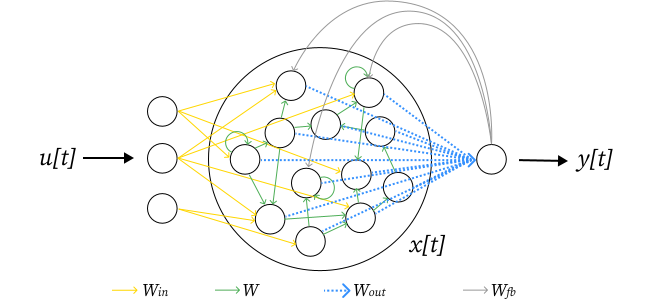


> We change the value of two hyperparameters:
> - $lr$: the leaking rate, which controls the time constant of the neurons;
> - $sr$: the spectral radius of the recurrent connections in the reservoir. It controls the chaoticity of the reservoir dynamics.


**Remarque perso**:

Lors de la prédiction on récupère une liste de taille `series` avec des tenseurs de taille `(timesteps, target)`.
Donc avec un simple `np.array` on retrouve le tenseur attendu de taille `(series, timesteps, target)`.

In [15]:
data = Input(input_dim=len(x_labels))
reservoir = Reservoir(100, lr=1.0, sr=1.0)
readout = Ridge(ridge=1e-6)

esn = data >> reservoir >> readout

In [16]:
esn.fit(x_train_3D, y_train_3D)

Running Model-1:   0%|          | 0/400 [00:00<?, ?it/s]

Running Model-1: 51it [00:00, 1139.18it/s]            
Running Model-1: 51it [00:00, 1558.57it/s]            
Running Model-1: 51it [00:00, 1365.48it/s]            13.17it/s]
Running Model-1: 51it [00:00, 1234.71it/s]            
Running Model-1: 51it [00:00, 2326.44it/s]            14.40it/s]
Running Model-1: 51it [00:00, 1152.00it/s]            
Running Model-1: 51it [00:00, 2179.37it/s]            14.23it/s]
Running Model-1: 51it [00:00, 1539.78it/s]            
Running Model-1: 51it [00:00, 1301.79it/s]            15.72it/s]
Running Model-1: 51it [00:00, 1210.67it/s]            
Running Model-1: 51it [00:00, 1640.25it/s]             15.44it/s]
Running Model-1: 51it [00:00, 3135.77it/s]            
Running Model-1: 51it [00:00, 3068.69it/s]            
Running Model-1: 51it [00:00, 3000.18it/s]             19.43it/s]
Running Model-1: 51it [00:00, 2130.45it/s]            
Running Model-1: 51it [00:00, 2479.74it/s]            
Running Model-1: 51it [00:00, 1064.05it/s]             20.

Fitting node Ridge-0...


'Model-1': Model('Input-0', 'Reservoir-0', 'Ridge-0')

## Prediction on train dataset (checking the ability to train)

In [17]:
y_check_3D = esn.run(x_train_3D)

Running Model-1: 51it [00:00, 2993.67it/s]            
Running Model-1: 51it [00:00, 2768.02it/s]            
Running Model-1: 51it [00:00, 2004.31it/s]            
Running Model-1: 51it [00:00, 3677.25it/s]            
Running Model-1: 51it [00:00, 3742.36it/s]            
Running Model-1: 51it [00:00, 2467.78it/s]            
Running Model-1: 51it [00:00, 3437.84it/s]            
Running Model-1: 51it [00:00, 1948.14it/s]            
Running Model-1: 51it [00:00, 2129.45it/s]            
Running Model-1: 51it [00:00, 2761.98it/s]            
Running Model-1: 51it [00:00, 2829.19it/s]            
Running Model-1: 51it [00:00, 2463.63it/s]            
Running Model-1: 51it [00:00, 2062.08it/s]            
Running Model-1: 51it [00:00, 3064.69it/s]            
Running Model-1: 51it [00:00, 3698.17it/s]            
Running Model-1: 51it [00:00, 3553.61it/s]            
Running Model-1: 51it [00:00, 3407.83it/s]            
Running Model-1: 51it [00:00, 3373.33it/s]            
Running Mo

In [18]:
y_check_scaled = np.array(y_check_3D).reshape(
    [N_series_train * N_times_train, len(y_labels)]
)
y_check = y_scaler.inverse_transform(y_check_scaled)

In [19]:
mean_squared_error(y_train, y_check)

np.float64(874.9584822617585)

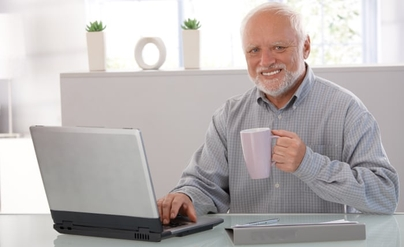

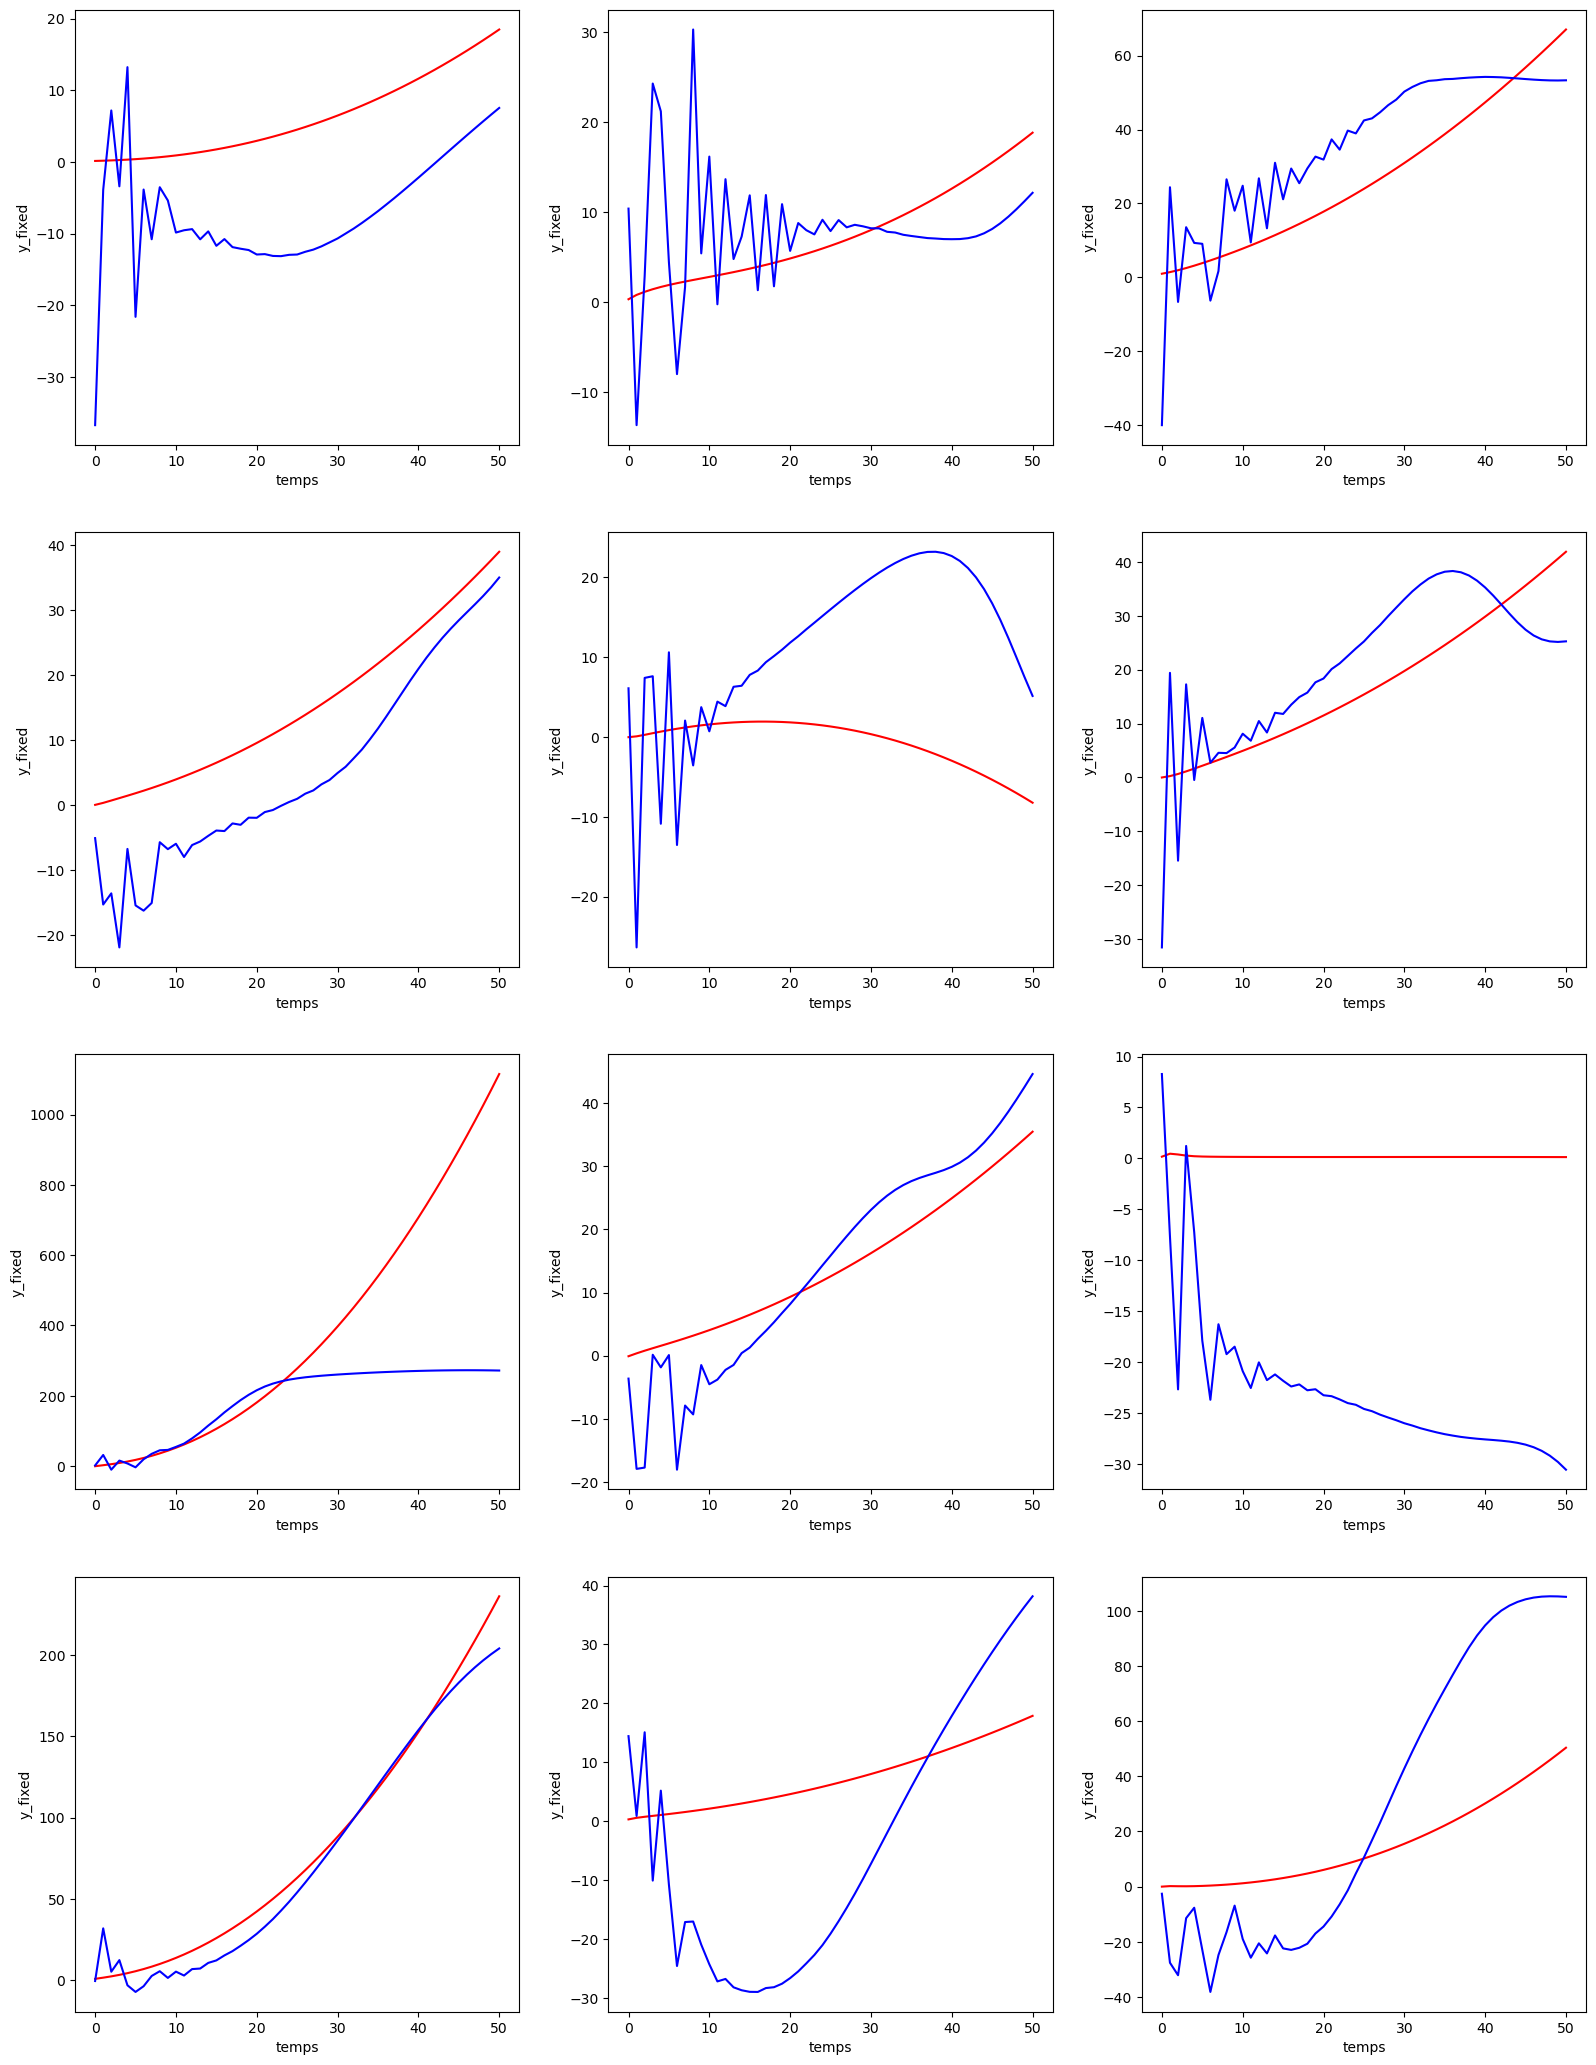

In [21]:
data_train["y_check"] = y_check
series_train = data_train[serie_column_name].unique()[:12]


NCOLS = 3
nrows = ceil(len(series_train) / NCOLS)


f, ax = plt.subplots(
    nrows=nrows,
    ncols=NCOLS,
    figsize=(6.5 * NCOLS, 6.5 * nrows),
)

for i_serie, serie in enumerate(series_train):
    irow = i_serie // NCOLS
    icol = i_serie % NCOLS
    data_plot = data_train[data_train[serie_column_name] == serie]

    sns.lineplot(
        x=data_plot[timestep_column_name],
        y=data_plot[y_labels[0]],
        ax=ax[irow, icol],
        color="red",
    )
    sns.lineplot(
        x=data_plot[timestep_column_name],
        y=data_plot["y_check"],
        ax=ax[irow, icol],
        color="blue",
    )

## Prediction on test dataset

In [22]:
y_hat_3D = esn.run(x_test_3D)

Running Model-1: 51it [00:00, 2431.67it/s]            
Running Model-1: 51it [00:00, 3517.55it/s]            
Running Model-1: 51it [00:00, 2284.31it/s]            
Running Model-1: 51it [00:00, 3036.72it/s]            
Running Model-1: 51it [00:00, 2563.76it/s]            
Running Model-1: 51it [00:00, 3479.84it/s]            
Running Model-1: 51it [00:00, 3521.78it/s]            
Running Model-1: 51it [00:00, 3652.02it/s]            
Running Model-1: 51it [00:00, 2863.73it/s]            
Running Model-1: 51it [00:00, 1513.73it/s]            
Running Model-1: 51it [00:00, 1537.32it/s]            
Running Model-1: 51it [00:00, 1230.91it/s]            
Running Model-1: 51it [00:00, 1080.66it/s]            
Running Model-1: 51it [00:00, 1309.61it/s]            
Running Model-1: 51it [00:00, 1129.81it/s]            
Running Model-1: 51it [00:00, 2122.86it/s]            
Running Model-1: 51it [00:00, 3930.71it/s]            
Running Model-1: 51it [00:00, 3709.01it/s]            
Running Mo

In [23]:
y_hat_scaled = np.array(y_hat_3D).reshape([N_series_test * N_times_test, len(y_labels)])
y_hat = y_scaler.inverse_transform(y_hat_scaled)

In [24]:
mean_squared_error(y_test, y_hat)

np.float64(537.3990574548328)

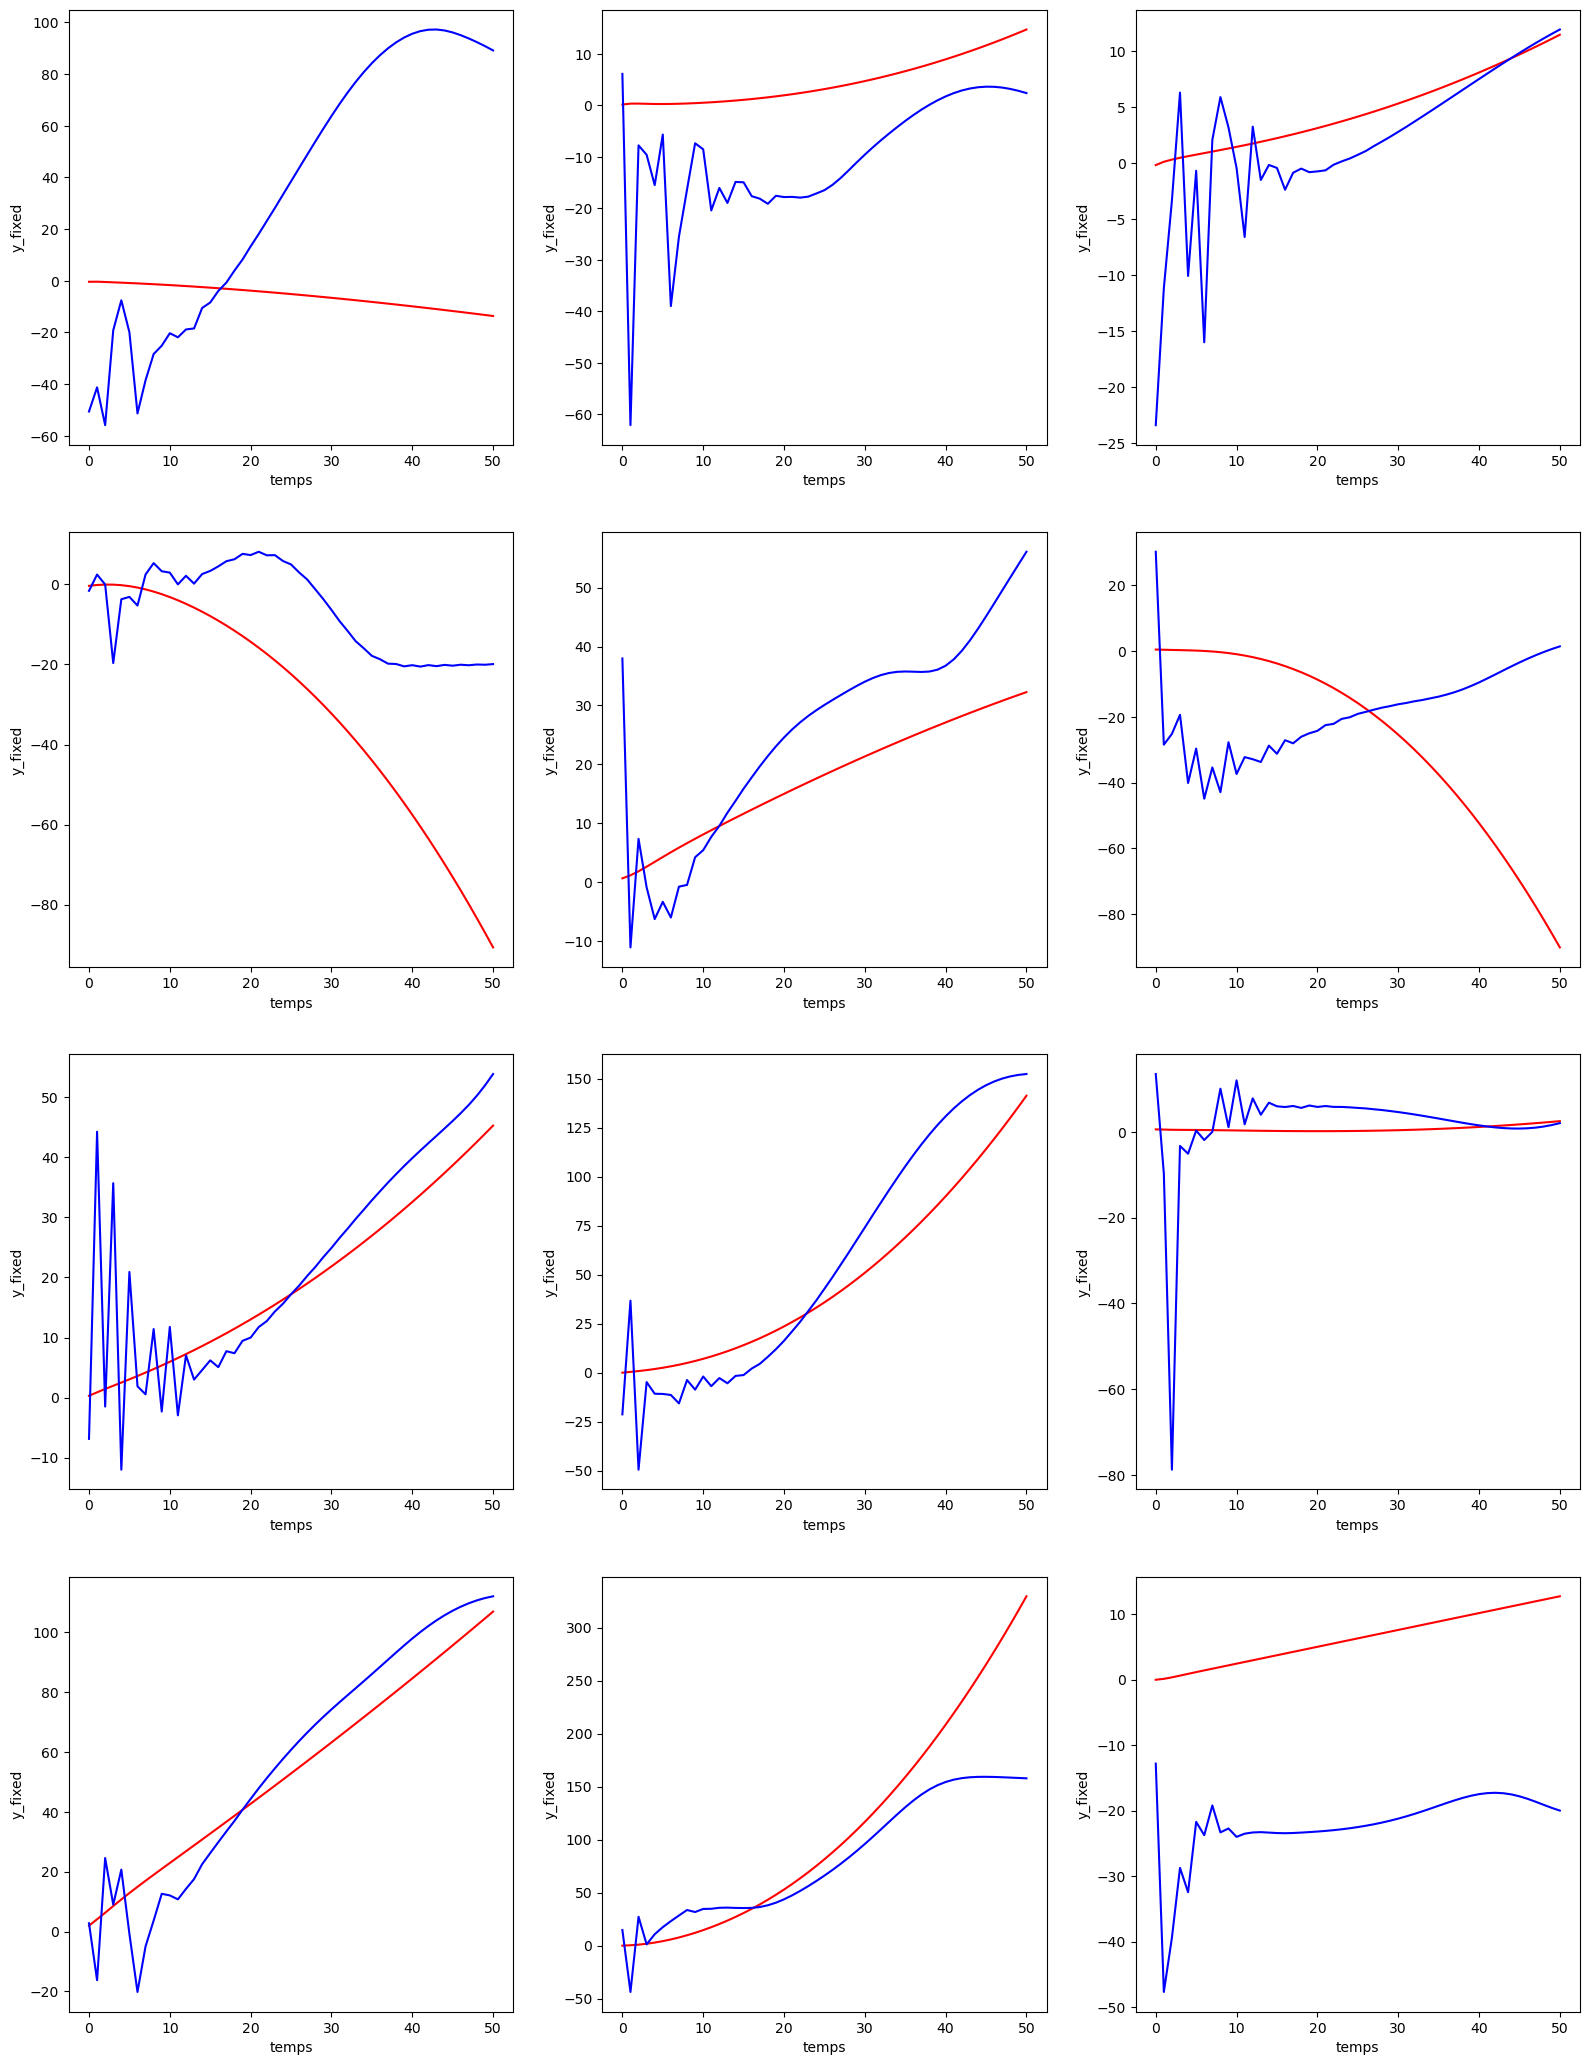

In [25]:
from math import ceil

data_test["y_hat"] = y_hat
series_test = data_test[serie_column_name].unique()[:12]


NCOLS = 3
nrows = ceil(len(series_test) / NCOLS)


f, ax = plt.subplots(
    nrows=nrows,
    ncols=NCOLS,
    figsize=(6.5 * NCOLS, 6.5 * nrows),
)

for i_serie, serie in enumerate(series_test):
    irow = i_serie // NCOLS
    icol = i_serie % NCOLS
    data_plot = data_test[data_test[serie_column_name] == serie]

    sns.lineplot(
        x=data_plot[timestep_column_name],
        y=data_plot[y_labels[0]],
        ax=ax[irow, icol],
        color="red",
    )
    sns.lineplot(
        x=data_plot[timestep_column_name],
        y=data_plot["y_hat"],
        ax=ax[irow, icol],
        color="blue",
    )

## Scikit-Learn pipeline

In [14]:
# ts_shape_changer = TimeSerieShapeChanger(serie_column_name, timestep_column_name)


# def func_forward(x):
#     return ts_shape_changer.df2D_to_array3D(x)


# def func_backward(x):
#     return ts_shape_changer.array3D_to_df2D(x)


# pipeline_transf_X = Pipeline(
#     [("Scaler", StandardScaler()), ("DimChange", func_forward)]
# )

# pipeline_transf_y = Pipeline(
#     [("Scaler", StandardScaler()), ("DimChange", func_forward)]
# )


# reservoir = Reservoir(100, lr=0.3, sr=1.1)
# readout = Ridge(ridge=1e-6)

# esn = reservoir >> readout


# regressor = TransformedTargetRegressor(regressor=esn, transformer=pipeline_transf_y)


# pipeline = Pipeline(
#     [("transf_X", pipeline_transf_X), ("transf_target_regressor", regressor)]
# )